In [180]:
import pandas as pd

import pickle 

import re
import string

import nltk
#nltk.download()

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy import displacy
from spacy.symbols import amod

from collections import Counter
from spacy.symbols import amod
from pprint import pprint

import scattertext as st

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn

# Get Data

In [8]:
with open('ted_video_transcripts_2416.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [80]:
df.head()

,video_id,transcript
0,YgAuFqEs6yk,I remember watching my father raised the pist...
1,bNmRr-BYnxA,Transcriber: Joseph Geni\nReviewer: Camille M...
2,FVUkKKc3Vvk,"Hi, everyone, my name is Elizabeth, and I wor..."
3,8bj0GR34XWc,Transcriber: Ivana Korom\nReviewer: Krystian ...
4,eaCrsBtiYA4,I am a public policy wonk. I investigate data...


In [10]:
len(df)

2416

# Text Preprocessing

In [75]:
def clean_transcript(dirty_line):
    output = ''
    for el in dirty_line: #df['transcript'].values[0]
        for key, value in el.items():
            line_output = str.join("", value)
            output += " " 
            output += line_output
    return output

In [79]:
df['transcript'] = df['transcript'].map(clean_transcript)

# SpaCy

In [11]:
nlp = spacy.load('en_core_web_sm')

In [81]:
doc = nlp(df['transcript'].values[0])

In [103]:
test = doc[:14]

In [104]:
for token in test:
    print(token.text, token.pos_, token.lemma_, token.is_stop)

  SPACE   False
I PRON -PRON- True
remember VERB remember False
watching VERB watch False
my DET -PRON- True
father NOUN father False
raised VERB raise False
the DET the True
pistol NOUN pistol False
to ADP to True
my DET -PRON- True
mother NOUN mother False
's PART 's True
head NOUN head False


In [105]:
test.text

" I remember watching my father raised the pistol to my mother's head"

In [106]:
test.sent

 I remember watching my father raised the pistol to my mother's head she pleaded with him to put the gun down

In [107]:
for token in test:
    print(token.text, token.dep_)

  
I nsubj
remember ROOT
watching xcomp
my poss
father nsubj
raised ccomp
the det
pistol dobj
to prep
my poss
mother poss
's case
head pobj


In [110]:
displacy.render(test, style='dep', options={'distance': 120})

In [113]:
for token in test:
    if token.dep_ == 'poss':
        print(f"posessive: {token.text} --> NOUN: {token.head}")

posessive: my --> NOUN: father
posessive: my --> NOUN: mother
posessive: mother --> NOUN: head


In [114]:
spacy.explain("poss")

'possession modifier'

named entity recognition

In [117]:
for ent in doc.ents:
    print(ent.text, ent.label_)

one CARDINAL
12 CARDINAL
years later DATE
nearly nine years DATE
only three CARDINAL
two CARDINAL
two CARDINAL
1983 DATE
11 years old DATE
Detroit GPE
30 years later DATE
19 year DATE
four years DATE
PhD WORK_OF_ART
GED ORG
Guana GPE
first ORDINAL
morning TIME
the morning TIME
Parenthood PERSON
the end of the day DATE
a long day DATE
Earth LOC
every day DATE
Mamas PERSON
two CARDINAL
one CARDINAL
two CARDINAL
my day DATE
first ORDINAL
Oprah Winfrey PERSON
CNN ORG
last night TIME
second ORDINAL
half an hour TIME
nightly DATE
night TIME
two CARDINAL
Sun PERSON
KU ORG
every night TIME


In [118]:
spacy.explain("PERSON")

'People, including fictional'

In [119]:
displacy.render(doc, style='ent', jupyter=True)

In [120]:
df['spacy_doc'] = list(nlp.pipe(df.transcript))

In [121]:
df.head()

,video_id,transcript,spacy_doc
0,YgAuFqEs6yk,I remember watching my father raised the pist...,"( , I, remember, watching, my, father, raised,..."
1,bNmRr-BYnxA,Transcriber: Joseph Geni\nReviewer: Camille M...,"( , Transcriber, :, Joseph, Geni, \n, Reviewer..."
2,FVUkKKc3Vvk,"Hi, everyone, my name is Elizabeth, and I wor...","( , Hi, ,, everyone, ,, my, name, is, Elizabet..."
3,8bj0GR34XWc,Transcriber: Ivana Korom\nReviewer: Krystian ...,"( , Transcriber, :, Ivana, Korom, \n, Reviewer..."
4,eaCrsBtiYA4,I am a public policy wonk. I investigate data...,"( , I, am, a, public, policy, wonk, ., I, inve..."


In [123]:
adj = [token.text.lower() for doc in df.spacy_doc for token in doc if token.pos_=='ADJ']
noun = [token.text.lower() for doc in df.spacy_doc for token in doc if token.pos_=='NOUN']

In [126]:
Counter(adj).most_common(12)

[('other', 7658),
 ('more', 6615),
 ('many', 5775),
 ('new', 4917),
 ('first', 4704),
 ('little', 4564),
 ('different', 4430),
 ('same', 4153),
 ('good', 4098),
 ('own', 3167),
 ('human', 3108),
 ('able', 2903)]

In [127]:
Counter(noun).most_common(12)

[('people', 18671),
 ('time', 9631),
 ('world', 8410),
 ('way', 7664),
 ('years', 7534),
 ('things', 6918),
 ('applause', 5415),
 ('life', 5360),
 ('thing', 4910),
 ('lot', 4500),
 ('day', 4264),
 ('laughter', 3876)]

In [130]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)

def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("IS:")
    pprint(get_amods(noun, df.spacy_doc))

In [131]:
amods_by_sentiment("talk")

Adjectives describing TALK:

IS:
['18-minute',
 '20-minute',
 'amazing',
 'amazing',
 'amazing',
 'astonishing',
 'average',
 'being',
 'big',
 'big',
 'boring',
 'courageous',
 'different',
 'entire',
 'extraordinary',
 'fancy',
 'fat',
 'first',
 'first',
 'first',
 'first',
 'first',
 'first',
 'first',
 'free',
 'full',
 'future',
 'good',
 'great',
 'great',
 'honest',
 'important',
 'improvised',
 'incredible',
 'inducing',
 'last',
 'little',
 'little',
 'major',
 'much',
 'much',
 'new',
 'next',
 'next',
 'nice',
 'only',
 'other',
 'other',
 'other',
 'other',
 'other',
 'otherizing',
 'perfect',
 'political',
 'popular',
 'popular',
 'powerful',
 'previous',
 'public',
 'public',
 'quick',
 'recorded',
 'remarkable',
 'second',
 'selling',
 'separate',
 'serious',
 'short',
 'small',
 'small',
 'small',
 'small',
 'small',
 'small',
 'special',
 'straight',
 'superficial',
 'synthetic',
 'technical',
 'terrorist',
 'varied',
 'viewed',
 'whole',
 'whole',
 'whole',
 'wonderf

# Scattertext

In [224]:
with open('ted_video_stats_2722.pkl', 'rb') as picklefile:
    stats = pickle.load(picklefile)

In [225]:
df1 = pd.merge(df, stats,  how='left', left_on='video_id', right_on = 'video_id')

In [226]:
df1

,video_id,transcript,spacy_doc,tags,title,publushed_date,comments_count,dislike_count,like_count,views_count,today,days_age,views_per_day,dislike_perc_of_likes,success,prime_tag
0,YgAuFqEs6yk,I remember watching my father raised the pist...,"( , I, remember, watching, my, father, raised,...","[Family, Parenting, Communication, Children, R...","How to co-parent as allies, not adversaries | ...",2020-05-14 14:40:00,109,86,722,23392,2020-05-16,1.0,23392.000000,11.911357,no,Family
1,bNmRr-BYnxA,Transcriber: Joseph Geni\nReviewer: Camille M...,"( , Transcriber, :, Joseph, Geni, \n, Reviewer...","[climate change, environment, global issues, c...",How to shift your mindset and choose your futu...,2020-05-13 14:22:51,205,136,2504,57548,2020-05-16,2.0,28774.000000,5.431310,no,climate change
2,FVUkKKc3Vvk,"Hi, everyone, my name is Elizabeth, and I wor...","( , Hi, ,, everyone, ,, my, name, is, Elizabet...","[Life, Society, Immigration, Humanity, Self, P...",What's missing from the American immigrant nar...,2020-05-12 18:06:31,234,257,1374,49720,2020-05-16,3.0,16573.333333,18.704512,no,Life
3,8bj0GR34XWc,Transcriber: Ivana Korom\nReviewer: Krystian ...,"( , Transcriber, :, Ivana, Korom, \n, Reviewer...","[global issues, science, collaboration, virus,...",A global pandemic calls for global solutions |...,2020-05-11 15:52:37,236,151,1225,42688,2020-05-16,4.0,10672.000000,12.326531,no,global issues
4,eaCrsBtiYA4,I am a public policy wonk. I investigate data...,"( , I, am, a, public, policy, wonk, ., I, inve...",[],Racism has a cost for everyone | Heather C. Mc...,2020-05-08 18:44:35,542,341,2156,60869,2020-05-16,7.0,8695.571429,15.816327,no,no_tags
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,HUM2rCIUdeI,"You know for me, the interest in contemporary...","( , You, know, for, me, ,, the, interest, in, ...","[Kevin, Bales, talks, slavery, human, traffick...",Kevin Bales: How to combat modern slavery,2010-03-29 14:59:48,258,46,1575,138339,2020-05-16,3700.0,37.388919,2.920635,yes,Kevin
2414,C_SBGTJgBGo,"One day, Los Angeles Times columnist Steve Lo...","( , One, day, ,, Los, Angeles, Times, columnis...","[Robert, Gupta, talks, Fellow, music, musician...","Robert Gupta: Music is medicine, music is sanity",2010-03-26 16:07:14,128,74,856,80565,2020-05-16,3703.0,21.756684,8.644860,no,Robert
2415,MLU7qcMYKO8,I want to talk about 4.6 billion years of his...,"( , I, want, to, talk, about, 4.6, billion, ye...","[Joel, Levine, talks, TEDxNASA, NASA, Mars, sp...",Joel Levine: Why we need to go back to Mars,2010-03-25 14:29:50,285,42,907,70218,2020-05-16,3704.0,18.957343,4.630650,yes,Joel
2416,yyemG7V5ynQ,"So, basically we have public leaders, public ...","( , So, ,, basically, we, have, public, leader...","[Alan, Siegel, talks, law, fine, print, legal,...",Alan Siegel: Let's simplify legal jargon!,2010-03-24 15:03:44,84,20,714,46789,2020-05-16,3705.0,12.628610,2.801120,yes,Alan


In [232]:
 corpus = st.CorpusFromPandas(df1,
                              category_col='success',
                              text_col='transcript',
                              nlp=st.whitespace_nlp_with_sentences
                             ).build()

In [234]:
 html1 = st.produce_scattertext_explorer(
         corpus,
         category='yes',
         category_name='Likable',
         not_category_name='Dislikable',
         minimum_term_frequency=10,
         pmi_threshold_coefficient=5,
         width_in_pixels=1000,
         #metadata=df1['prime_tag']
         metadata=corpus.get_df()['prime_tag']
         )

In [223]:
open('demo.html', 'wb').write(html.encode('utf-8'));

In [236]:
open('demo1.html', 'wb').write(html1.encode('utf-8'));

# CorEx

In [142]:
!pip install corextopic
!pip install networkx

  Created wheel for corextopic: filename=corextopic-1.0.5-py3-none-any.whl size=22373 sha256=ef74190a4dd3510b9c3c125d4d5780779e56878d7a2593d0519eb4049ff6306e
  Stored in directory: /Users/elena/Library/Caches/pip/wheels/0e/20/09/30c3de6ad22b7ae3d29d38200cc3217c8813ee17934dfb99b9
Successfully built corextopic


In [147]:
import scipy.sparse as ss
import numpy as np

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [148]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=2.0, min_df=3,strip_accents='ascii') 

#CountVectorizer(max_features=20000,
#                             stop_words='english',
#                             binary=True)

doc_word = vectorizer.fit_transform(df.transcript)
words = list(np.asarray(vectorizer.get_feature_names()))

In [150]:
df.head()

,video_id,transcript,spacy_doc
0,YgAuFqEs6yk,I remember watching my father raised the pist...,"( , I, remember, watching, my, father, raised,..."
1,bNmRr-BYnxA,Transcriber: Joseph Geni\nReviewer: Camille M...,"( , Transcriber, :, Joseph, Geni, \n, Reviewer..."
2,FVUkKKc3Vvk,"Hi, everyone, my name is Elizabeth, and I wor...","( , Hi, ,, everyone, ,, my, name, is, Elizabet..."
3,8bj0GR34XWc,Transcriber: Ivana Korom\nReviewer: Krystian ...,"( , Transcriber, :, Ivana, Korom, \n, Reviewer..."
4,eaCrsBtiYA4,I am a public policy wonk. I investigate data...,"( , I, am, a, public, policy, wonk, ., I, inve..."


In [151]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df.transcript)

In [152]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: said,didn,say,did,got,talk,feel,person,told,don
1: country,political,rights,government,social,united,family,community,leaders,violence
2: percent,problem,need,companies,better,health,economic,dollars,market,problems
3: science,cells,scientists,lab,humans,biology,body,human,using,animal
4: water,species,earth,plants,ocean,planet,surface,carbon,sea,atmosphere
5: climate,billion,global,million,scale,000,large,data,resources,systems


In [156]:
#key docs associated with a topic
# Let's check out topic : 3
topic_model.get_top_docs(topic=5, n_docs=1)

[(' Translator: Joseph Geni\nReviewer: Morton Bast When we use the word "architect" or "designer," what we usually mean is a professional, someone who gets paid, and we tend to assume that it\'s those professionals who are going to be the ones to help us solve the really big, systemic design challenges that we face like climate change, urbanization and social inequality. That\'s our kind of working presumption. And I think it\'s wrong, actually. In 2008, I was just about to graduate from architecture school after several years, and go out and get a job, and this happened. The economy ran out of jobs. And a couple of things struck me about this. One, don\'t listen to career advisers. And two, actually this is a fascinating paradox for architecture, which is that, as a society, we\'ve never needed design thinking more, and yet architecture was literally becoming unemployed. It strikes me that we talk very deeply about design, but actually there\'s an economics behind architecture that we

In [157]:
topic_model.labels

array([[ True,  True, False, False, False, False],
       [ True,  True,  True, False, False,  True],
       [ True,  True, False, False, False, False],
       ...,
       [False, False,  True,  True,  True,  True],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [158]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

,topic0,topic1,topic2,topic3,topic4,topic5
0,True,True,False,False,False,False
1,True,True,True,False,False,True
2,True,True,False,False,False,False


In [161]:
topic_model.p_y_given_x

array([[9.99999000e-01, 9.99999000e-01, 1.00000000e-06, 1.00000000e-06,
        1.00000000e-06, 1.00000000e-06],
       [9.99999000e-01, 9.99999000e-01, 9.99999000e-01, 1.00000000e-06,
        1.00000000e-06, 9.99999000e-01],
       [9.99999000e-01, 9.99999000e-01, 1.00000000e-06, 1.00000000e-06,
        1.00000000e-06, 1.00000000e-06],
       ...,
       [1.00000000e-06, 1.00000000e-06, 9.97269573e-01, 9.99999000e-01,
        9.99999000e-01, 9.99999000e-01],
       [1.00000000e-06, 1.00000000e-06, 3.31760486e-06, 1.00000000e-06,
        1.00000000e-06, 1.00000000e-06],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
        5.94913013e-05, 1.00000000e-06]])

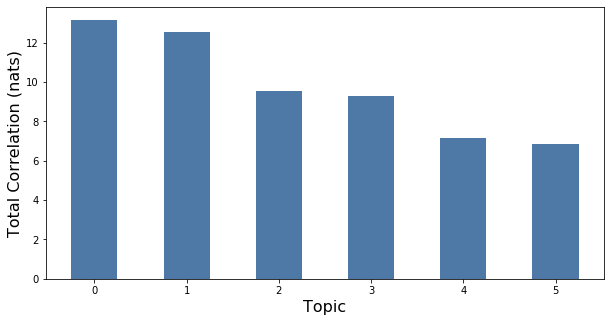

In [162]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [163]:
topic_model.tcs

array([13.15177315, 12.52577995,  9.56197997,  9.2848201 ,  7.14461909,
        6.82588517])

In [166]:
#anchoring
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.transcript, 
                anchors=[['government', 'political'], 
                         ['health', 'economic'], 
                         ['science', 'human'], 
                         ['earth', 'planet'],
                         ['climate']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: political,government,said,country,rights,told,men,violence,women,family
1: health,economic,percent,dollars,economy,countries,care,risk,population,need
2: science,human,actually,thing,does,probably,bit,interesting,right,things
3: earth,planet,species,water,surface,ocean,size,animals,scientists,nature
4: climate,global,carbon,million,scale,billion,emissions,land,energy,food


In [168]:
#force with anchors to get smaller topics
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.transcript, 
                anchors=[['virus', 'health'], 'virus'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: health,virus,disease,care,percent,medical,patients,healthy,treatment,diseases
1: virus,actually,problem,science,probably,data,use,example,does,better
2: history,art,language,read,media,book,century,great,books,written
3: said,family,woman,didn,told,country,men,children,friends,women
4: global,climate,scale,million,billion,water,economy,earth,000,need


In [170]:
#use same words in the different topics
#anchors

#women
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.transcript, 
                anchors=[['virus'], ['virus'], ['virus'], ['virus']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: virus,species,technology,scientists,using,science,planet,carbon,surface,technologies
1: percent,virus,year,million,population,50,000,climate,30,number
2: economy,economic,business,government,political,companies,dollars,global,market,governments
3: virus,disease,patients,medical,health,patient,diseases,cancer,doctors,treatment
4: bit,thing,little,stuff,probably,kind,actually,great,sort,things
5: country,city,south,community,war,local,africa,communities,north,america
6: children,women,education,girls,families,support,schools,gender,equality,objects
7: said,didn,felt,family,told,friends,man,men,wasn,feel


# Sentiment Analysis Vader

In [173]:
analyser = SentimentIntensityAnalyzer()

In [176]:
analyser.polarity_scores(df['transcript'].values[0])

{'neg': 0.078, 'neu': 0.728, 'pos': 0.194, 'compound': 0.9998}

# LDA PyViz

In [177]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,                # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df.transcript)

In [178]:
n_components = 10

lda_model = LatentDirichletAllocation(n_components=n_components,   # Number of topics
                                      max_iter=10,                 # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,            # Random state
                                      #batch_size=128,             # n docs in each learning iter
                                      n_jobs = -1,                 # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [181]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.055022 -0.088597       1        1  22.912454
8     -0.014855  0.020415       2        1  17.915434
7     -0.090149 -0.016953       3        1  14.061542
6      0.072517 -0.003636       4        1  10.126837
2      0.058091  0.132755       5        1   6.858479
9      0.136173 -0.061365       6        1   6.739729
4      0.013190 -0.085290       7        1   6.280845
3      0.090023  0.032185       8        1   5.367386
1     -0.102877  0.138678       9        1   5.085036
5     -0.107091 -0.068191      10        1   4.652259, topic_info=    Category         Freq    Term         Total  loglift  logprob
971  Default  3360.000000   women   3360.000000  30.0000  30.0000
82   Default  2194.000000   brain   2194.000000  29.0000  29.0000
384  Default  2162.000000  health   2162.000000  28.0000  28.0000
549  Default  1690.000000     men   1690.000000  27.0000  27.0000
578  Default  1778.000000   music   1778.000000  26.0000  26.0000
..       ...          ...     ...           ...      ...      ...
730  Topic10   299.524182   right   6826.632467  -0.0586  -5.1403
885  Topic10   306.118302   think  10468.192690  -0.4643  -5.1185
958  Topic10   280.508384     way   7853.946053  -0.2644  -5.2059
586  Topic10   268.022784    need   5908.103068  -0.0252  -5.2514
890  Topic10   262.550882    time   9656.443971  -0.5371  -5.2720

[570 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.014470    000
0         2  0.214852    000
0         3  0.169251    000
0         4  0.111811    000
0         5  0.138996    000
...     ...       ...    ...
998       6  0.001237  young
998       7  0.014225  young
998       8  0.012988  young
998       9  0.018555  young
998      10  0.161428  young

[3104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 7, 3, 10, 5, 4, 2, 6])

In [84]:
#stemmer=LancasterStemmer()
#porter=PorterStemmer()

In [85]:
englishStemmer=SnowballStemmer("english", ignore_stopwords=True)
def stemComment(comment_line):
    token_words=word_tokenize(comment_line)
    stem_line=[]
    for word in token_words:
        stem_line.append(englishStemmer.stem(word))
        stem_line.append(" ")
    return "".join(stem_line)

In [86]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(comment_line):
    token_words=word_tokenize(str(comment_line))
    filtered_comment_line = [w for w in token_words if not w in stop_words] 
    
    return " ".join(filtered_comment_line)

In [87]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [88]:
df['transcript'] = df['transcript'].map(remove_stop_words).map(alphanumeric).map(punc_lower)

In [89]:
#https://stackoverflow.com/questions/29270917/removing-custom-stop-words-form-a-phrase-in-python
my_stop_words_lst = ['ted', 'text', 'thank', 'you']

for w in my_stop_words_lst:
    pattern = r'\b'+w+r'\b'
    custom_stop = lambda x: re.sub(pattern, ' ', x)
    df['transcript'] = df['transcript'].map(custom_stop)

In [90]:
df['transcript'] = df['transcript'].map(stemComment)

In [91]:
df.head()

,video_id,transcript
0,YgAuFqEs6yk,i rememb watch father rais pistol mother s hea...
1,bNmRr-BYnxA,transcrib joseph geni nreview camill martínez ...
2,FVUkKKc3Vvk,hi everyon name elizabeth and i work trade flo...
3,8bj0GR34XWc,transcrib ivana korom nreview krystian aparta ...
4,eaCrsBtiYA4,i public polici wonk i investig data point pro...


In [92]:
df['transcript'][1]

'transcrib joseph geni nreview camill martínez i never thought i would give nmi talk somewher like but like half human i ve spent last nfour week lockdown due global pandem ncreat covid i extrem fortun nthat time i ve abl come wood nnear home southern england these wood alway inspir and human tri think about nhow find inspir to retak control action terribl thing ndo n t come road without us take action avert i thought good place nfor us talk and i d like begin nthat stori six year ago when i first join nthe unit nation now i firm believ nthat un unparallel import in world right to promot collabor cooper but n t tell join is essenti work deliv main form nof extrem bore meet extrem long bore meet now may feel attend nsome long bore meet life i m sure but un meet next level and everyon work there napproach level calm normal achiev zen master but i n t readi i join expect drama nand tension breakthrough what i n t readi was process seem move nat speed glacier at speed glacier nuse move now

# Build Document-Term matrix

In [93]:
vectorizer = TfidfVectorizer(stop_words='english') 
doc_word = vectorizer.fit_transform(list(df.transcript))
doc_word

<2416x39840 sparse matrix of type '<class 'numpy.float64'>'
	with 1012696 stored elements in Compressed Sparse Row format>

In [94]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).shape

(2416, 39840)

In [95]:
dtm = pd.DataFrame(doc_word.toarray(), index=df['video_id'], columns=vectorizer.get_feature_names())

# Topic Modeling

In [96]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


### Latent Semantic Analysis (LSA)

In [100]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(dtm)
lsa.explained_variance_ratio_

array([0.00691832, 0.00867407, 0.00722984, 0.00638489, 0.00584166,
       0.00547615, 0.00517708, 0.0046375 , 0.00452422, 0.00410085])

In [101]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaargh,aaaaaah,aaaab,aaaah,aaaahhh,...,ān,čapek,ōfunato,ʾan,ʾilla,ʾilāha,อย,อยman,อร,送你葱
component_1,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0
component_2,-0.001,0.000,-0.000,-0.0,0.001,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.000,-0.000,-0.000,0.0
component_3,0.001,-0.000,0.002,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.001,0.001,0.002,-0.0
component_4,0.001,-0.000,-0.001,-0.0,0.000,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.000,-0.000,-0.001,-0.0
component_5,-0.001,0.002,-0.000,0.0,-0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.001,0.001,0.001,0.0
component_6,-0.000,0.000,0.001,0.0,-0.000,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000,0.000,0.001,0.0
component_7,-0.001,0.000,0.002,-0.0,-0.000,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000,0.0
component_8,0.000,-0.000,-0.000,0.0,-0.001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000,0.000,0.001,0.0
component_9,-0.001,-0.001,-0.000,-0.0,0.001,-0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,-0.0
component_10,0.000,-0.000,-0.001,0.0,-0.001,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000,0.000,0.000,0.0


In [102]:
display_topics(lsa, vectorizer.get_feature_names(), 15)


Topic  0
peopl, nto, like, nand, nof, nthat, think, thing, know, time, laughter, year, work, want, make

Topic  1
women, girl, men, school, children, said, famili, woman, parent, kid, mother, educ, peopl, young, nand

Topic  2
music, laughter, like, brain, thing, play, love, know, song, video, feel, robot, said, sound, realli

Topic  3
cell, brain, cancer, patient, diseas, nto, women, drug, nthat, nand, health, bodi, doctor, nof, medic

Topic  4
peopl, data, patient, think, inform, health, actual, govern, drug, thing, cancer, compani, know, diseas, countri

Topic  5
women, music, cell, water, ocean, girl, men, cancer, fish, planet, diseas, year, children, patient, anim

Topic  6
music, patient, health, applaus, nof, nto, govern, countri, guitar, sound, technolog, play, drug, compani, song

Topic  7
women, robot, men, girl, comput, woman, ai, gender, machin, sex, femal, data, technolog, sexual, imag

Topic  8
school, robot, design, citi, kid, build, student, children, educ, teacher, gi

In [62]:
lsa.components_

array([[ 9.68620709e-05,  1.03763392e-04,  7.48935844e-05, ...,
         2.98614931e-05,  5.97229861e-05,  1.11542964e-05],
       [ 1.88035532e-05,  1.64924212e-04,  4.20325867e-03, ...,
         6.46077822e-04,  1.29215564e-03,  2.59712183e-05],
       [ 1.10812732e-03, -5.44983553e-04, -1.47105038e-04, ...,
         1.22011256e-04,  2.44022511e-04, -8.35359701e-05],
       [ 3.75091143e-04,  5.80494082e-05,  3.32403708e-04, ...,
         1.41503516e-04,  2.83007031e-04, -1.28096529e-04],
       [ 2.62605934e-04, -1.35827142e-03,  7.39542845e-04, ...,
        -7.08270320e-04, -1.41654064e-03, -2.02189834e-04]])

In [63]:
doc_topic_lsa = pd.DataFrame(doc_topic,
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
doc_topic_lsa

,component_1,component_2,component_3,component_4,component_5
video_id,,,,,
YgAuFqEs6yk,0.890676,0.042962,-0.056709,0.004102,-0.062049
bNmRr-BYnxA,0.883629,-0.040627,-0.010975,-0.019726,0.053228
FVUkKKc3Vvk,0.885644,-0.025310,-0.068833,0.007190,0.038097
8bj0GR34XWc,0.848307,-0.024130,0.027906,0.039088,0.000483
eaCrsBtiYA4,0.852875,-0.035804,-0.060799,-0.018492,0.026517
...,...,...,...,...,...
HUM2rCIUdeI,0.838504,0.006174,-0.023050,-0.043234,-0.045791
C_SBGTJgBGo,0.665815,0.252792,-0.011495,0.026302,0.079951
MLU7qcMYKO8,0.682086,0.002008,0.119328,-0.127289,0.008149


In [64]:
cosine_similarity((doc_topic_lsa.values[0], 
                   doc_topic_lsa.values[1], 
                   doc_topic_lsa.values[3],  
                   doc_topic_lsa.values[4], 
                   doc_topic_lsa.values[5], 
                   doc_topic_lsa.values[6]))

array([[1.        , 0.98557882, 0.98916038, 0.99057338, 0.98948304,
        0.9254981 ],
       [0.98557882, 1.        , 0.99472814, 0.99785056, 0.99538184,
        0.94692381],
       [0.98916038, 0.99472814, 1.        , 0.99177268, 0.99965085,
        0.96728182],
       [0.99057338, 0.99785056, 0.99177268, 1.        , 0.99180318,
        0.93060307],
       [0.98948304, 0.99538184, 0.99965085, 0.99180318, 1.        ,
        0.96603434],
       [0.9254981 , 0.94692381, 0.96728182, 0.93060307, 0.96603434,
        1.        ]])

In [109]:
#cosine_similarity((doc_topic_lsa.values[0], doc_topic_lsa.values[6]))

### NMF (Non-Negative Matrix Factorization)

In [65]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [66]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaargh,aaaaaah,aaaab,aaaah,aaaahhh,...,ān,čapek,ōfunato,ʾan,ʾilla,ʾilāha,อย,อยman,อร,送你葱
component_1,0.000,0.001,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0
component_2,0.000,0.000,0.007,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.001,0.0
component_3,0.001,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0
component_4,0.001,0.000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0
component_5,0.000,0.000,0.000,0.0,0.001,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001,0.001,0.001,0.0,0.0,0.000,0.0


In [67]:
display_topics(nmf_model, vectorizer.get_feature_names(), 14)


Topic  0
text, peopl, like, thing, think, know, laughter, want, time, realli, ve, say, make, year

Topic  1
music, text, applaus, guitar, play, song, sound, cheer, sing, cello, musician, end, compos, nois

Topic  2
text, water, planet, ocean, earth, nof, fish, climat, nto, energi, carbon, mar, solar, nand

Topic  3
text, cell, cancer, brain, patient, diseas, drug, dna, gene, protein, blood, bodi, health, tumor

Topic  4
text, nto, nand, nthat, nof, women, nin, nthe, nfor, na, peopl, nis, communiti, nwith


In [68]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
doc_topic_nmf

,component_1,component_2,component_3,component_4,component_5
video_id,,,,,
YgAuFqEs6yk,0.14555,0.00648,0.00000,0.00000,0.01010
bNmRr-BYnxA,0.11341,0.00000,0.05289,0.00312,0.03076
FVUkKKc3Vvk,0.12999,0.00000,0.00000,0.00000,0.04142
8bj0GR34XWc,0.11079,0.00000,0.01119,0.07735,0.01531
eaCrsBtiYA4,0.12552,0.00000,0.00304,0.00000,0.03675
...,...,...,...,...,...
HUM2rCIUdeI,0.13222,0.00023,0.01592,0.00000,0.00846
C_SBGTJgBGo,0.08482,0.17426,0.00000,0.00077,0.00000
MLU7qcMYKO8,0.03039,0.00000,0.22262,0.00000,0.00000


In [69]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[1]))

array([[1.        , 0.89336073],
       [0.89336073, 1.        ]])

In [70]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[26]))

array([[1.        , 0.31067444],
       [0.31067444, 1.        ]])

### LDA

Changing vectorizer from TF-IDF

In [71]:
vectorizer = CountVectorizer(stop_words='english') 
doc_word = vectorizer.fit_transform(list(df.transcript))
doc_word

<2416x39840 sparse matrix of type '<class 'numpy.int64'>'
	with 1017301 stored elements in Compressed Sparse Row format>

In [72]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).shape

(2416, 39840)

In [73]:
dtm = pd.DataFrame(doc_word.toarray(), index=df['video_id'], columns=vectorizer.get_feature_names())

In [74]:
lda = LatentDirichletAllocation(n_components=5)

In [75]:
doc_topic = lda.fit_transform(dtm)


In [76]:
lda.score

<bound method LatentDirichletAllocation.score of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)>

In [77]:
topic_word = pd.DataFrame(lda.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaargh,aaaaaah,aaaab,aaaah,aaaahhh,...,ān,čapek,ōfunato,ʾan,ʾilla,ʾilāha,อย,อยman,อร,送你葱
component_1,0.200,2.361,0.200,0.200,0.2,0.2,0.200,0.2,0.200,0.200,...,0.208,0.200,0.200,0.202,0.202,0.202,0.200,0.200,0.200,0.207
component_2,0.200,0.200,0.201,0.200,0.2,0.2,0.200,0.2,0.200,0.200,...,0.200,0.200,0.211,0.200,0.200,0.200,0.200,0.200,0.200,0.200
component_3,0.212,0.203,0.214,0.201,0.2,0.2,1.198,0.2,0.475,0.200,...,0.200,0.336,0.200,0.200,0.200,0.200,0.219,0.219,0.215,0.200
component_4,0.203,6.504,0.201,0.200,1.2,0.2,0.201,0.2,0.202,0.208,...,0.201,1.059,1.180,1.198,1.198,1.198,0.202,0.202,0.202,0.204
component_5,10.185,0.732,4.184,2.199,0.2,1.2,0.201,1.2,0.923,1.192,...,1.191,0.204,0.208,0.200,0.200,0.200,1.179,1.179,2.183,1.189


In [78]:
display_topics(lda, vectorizer.get_feature_names(), 15)


Topic  0
text, peopl, nto, nand, nthat, countri, nof, work, think, nin, world, nthe, thing, right, like

Topic  1
text, citi, build, water, nof, design, space, nto, nand, use, materi, nthat, earth, energi, nin

Topic  2
text, like, use, brain, nto, make, thing, think, time, nof, realli, cell, nthat, way, work

Topic  3
text, peopl, like, nto, nand, know, nthat, laughter, time, nof, year, want, say, think, said

Topic  4
text, like, know, think, peopl, year, thing, look, realli, time, world, actual, ve, make, use


In [79]:
lda.components_

array([[0.20000031, 0.20000031, 0.20000031, ..., 0.20000702, 0.20000031,
        0.20000031],
       [0.20054092, 0.20054092, 0.20054092, ..., 0.21819025, 0.20054092,
        0.20054092],
       [0.20000031, 0.20000031, 0.20000031, ..., 0.20000713, 0.20000031,
        0.20000031],
       [0.20000031, 0.20000031, 0.20000031, ..., 0.20000714, 0.20000031,
        0.20000031],
       [0.20025767, 0.20025767, 0.20025767, ..., 0.20737333, 0.20025767,
        0.20025767]])

In [80]:
doc_topic_lda = pd.DataFrame(doc_topic.round(5),
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
doc_topic_lda

,component_1,component_2,component_3,component_4,component_5
video_id,,,,,
_5DXs8xxaMU,0.01856,0.92575,0.01856,0.01856,0.01856
DNrMPF3I_bs,0.01291,0.94838,0.01290,0.01290,0.01290
TwN8soCzjPM,0.01373,0.94509,0.01373,0.01373,0.01373
8OMUdYoIJhI,0.01509,0.93965,0.01509,0.01509,0.01509
xk_MHfOAfRQ,0.01924,0.92306,0.01923,0.01923,0.01923
...,...,...,...,...,...
qlH5-G576fQ,0.01129,0.95486,0.01128,0.01128,0.01128
uLXyFJEbj_s,0.01758,0.92969,0.01758,0.01758,0.01758
A3riThai7MU,0.02080,0.91681,0.02080,0.02080,0.02080


In [81]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[1]))

array([[1.        , 0.96752052],
       [0.96752052, 1.        ]])

In [55]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[136]))

array([[1.        , 0.84052477],
       [0.84052477, 1.        ]])